In [37]:
import pandas as pd
type = "summary_100"

type_train_df_x = pd.read_parquet(f"df/{type}_train_df_x.gzip")
type_test_df_x = pd.read_parquet(f"df/{type}_test_df_x.gzip")

type_train_df_y = pd.read_parquet(f"df/{type}_train_df_y.gzip")
type_test_df_y = pd.read_parquet(f"df/{type}_test_df_y.gzip")
joined_train_df = pd.concat([type_train_df_x, type_train_df_y], axis=1).reset_index(drop=True)
joined_test_df = pd.concat([type_test_df_x, type_test_df_y], axis=1).reset_index(drop=True)

joined = pd.concat([joined_train_df, joined_test_df], axis=0).reset_index(drop=True)

In [38]:
joined = joined.drop("id", axis=1)

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_stacked_bar_by_bias_and_sentiment(df, int_bias_col, sentiment_col, topic_col, type):
    """
    Creates a stacked bar chart with:
    - percentage distribution of sentiment per int_bias (only where topic_col == True)
    - count annotations within each segment
    - total count per bias class above each bar
    """
    # Filter to topic == True
    filtered = df[df[topic_col] == True]

    label_map = {'0': 'left', '1': 'center', '2': 'right'}
    order = ['left', 'center', 'right']

    # Total count per 
    filtered['int_bias'] = filtered['int_bias'].astype(str).replace(label_map)
    filtered['int_bias'] = pd.Categorical(filtered[int_bias_col], categories=order, ordered=True)
    total_per_bias = filtered.groupby(int_bias_col).size().rename("total_per_bias")

    # Count per (bias, sentiment)
    grouped = (
        filtered
        .groupby([int_bias_col, sentiment_col])
        .size()
        .reset_index(name="count")
        .merge(total_per_bias, on=int_bias_col)
    )
    grouped["percent"] = 100 * grouped["count"] / grouped["total_per_bias"]

    # Pivot for stacked bar plot
    pivot_percent = grouped.pivot(index=int_bias_col, columns=sentiment_col, values="percent")
    pivot_count = grouped.pivot(index=int_bias_col, columns=sentiment_col, values="count")
    total_counts = total_per_bias.loc[pivot_percent.index]

    # Ensure index is in the correct order
    pivot_percent = pivot_percent.loc[order]
    pivot_count = pivot_count.loc[order]
    total_counts = total_counts.loc[order]

    # Plot
    ax = pivot_percent.plot(
        kind="bar",
        stacked=True,
        figsize=(10, 6),
        colormap="tab10",
        edgecolor="black"
    )

    plt.title(f"100 Word Summary: Sentiment Distribution per Bias Class (Politics)")
    plt.xlabel("Bias Class")
    plt.ylabel("Percentage")
    plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(axis="y", linestyle="--", linewidth=0.5)

    # Annotate each segment with its count
    for idx, bias_class in enumerate(pivot_count.index):
        y_offset = 0
        for sentiment in pivot_count.columns:
            count = pivot_count.loc[bias_class, sentiment]
            height = pivot_percent.loc[bias_class, sentiment]
            if count > 0:
                ax.text(
                    idx,
                    y_offset + height / 2,
                    f"{int(count)}",
                    ha="center",
                    va="center",
                    fontsize=9,
                    color="black"
                )
                y_offset += height

        # Add total count label above the bar
        ax.text(
            idx,
            105,  # place above 100%
            f"n={int(total_counts.loc[bias_class])}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold"
        )

    
    plt.ylim(0, 110)  # leave space for total count labels
    plt.savefig(f"results/{type}_sentiment_dist.png", bbox_inches='tight')

    plt.tight_layout()
    plt.show()


/var/folders/fz/y03qr7rx39zcncb4x6fsnclm0000gn/T/ipykernel_84251/2748326057.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['int_bias'] = filtered['int_bias'].astype(str).replace(label_map)
/var/folders/fz/y03qr7rx39zcncb4x6fsnclm0000gn/T/ipykernel_84251/2748326057.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['int_bias'] = pd.Categorical(filtered[int_bias_col], categories=order, ordered=True)
/var/folders/fz/y03qr7rx39zcncb4x6fsnclm0000gn/T/ipykernel_84251/2748326057.py:20: Fu

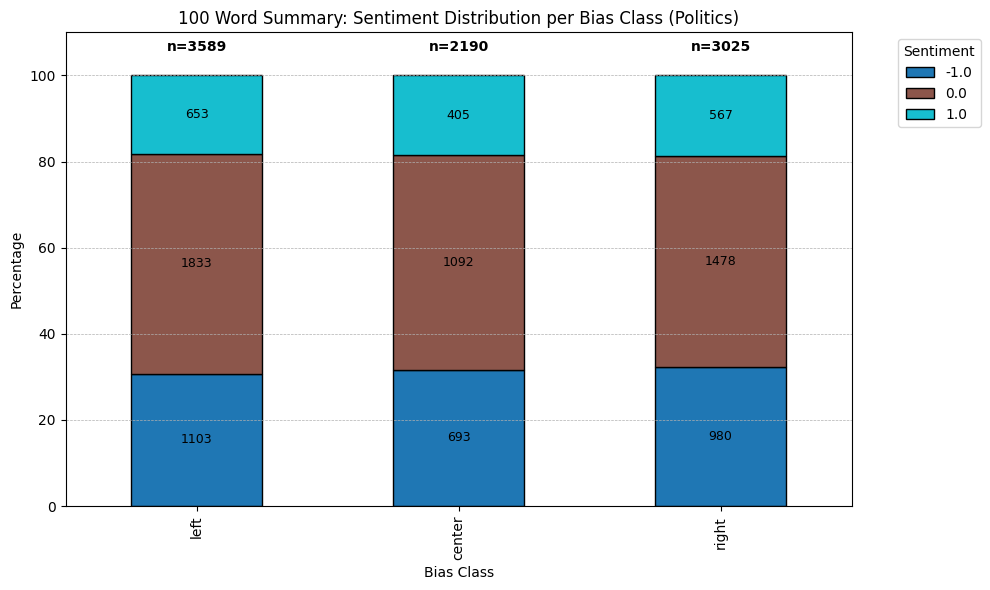

In [40]:
plot_stacked_bar_by_bias_and_sentiment(df=joined,
int_bias_col='int_bias',
sentiment_col='sentiment Politics',
topic_col='topic Politics',
type=type
)

In [26]:
def count_true_per_column(df, columns):

    df = df[columns]
    sorted = df.astype(bool).sum().sort_values(ascending=False)
    return sorted[sorted > 0]

In [27]:
topics = [col for col in joined.columns if col.startswith("topic")]
media_bias = joined[joined["topic Politics"] == True]
res = count_true_per_column(media_bias, topics)

In [28]:
res.head()

topic Politics        8363
topic White House     1867
topic Donald Trump    1523
topic US House         858
topic US Senate        845
dtype: int64

In [29]:
res.to_csv("articles_by_topic_count.csv")

In [20]:
def return_bias_value_counts(filter_1, filter_2):
    res = joined[(joined[filter_1] == True) & (joined[filter_2] == True)]
    return res['int_bias'].value_counts().sort_index()

In [21]:
return_bias_value_counts("topic Media Bias", "topic Donald Trump")

int_bias
0    88
1    63
2    70
Name: count, dtype: Int64

,topic Defense And Security,topic Democratic Party,topic FOREIGN POLICY,topic Politics,topic 14th Amendment,topic 1619 Project,topic 1st Amendment,topic 2012,topic 2014,topic 2016 Election,...,759,760,761,762,763,764,765,766,767,int_bias
61,False,False,False,False,False,False,False,False,False,False,...,-0.008721,0.009897,0.043613,0.020632,-0.022974,0.02293,0.015214,-0.022722,-0.015034,0
97,False,False,False,False,False,False,False,False,False,False,...,0.040887,-0.012244,0.049417,0.03136,0.077825,-0.035012,-0.022565,-0.029243,-0.040688,0
217,False,False,False,False,False,False,False,False,False,False,...,0.006802,-0.041615,0.005588,-0.028909,0.043295,-0.008607,-0.011471,0.008774,-0.010514,1
219,False,False,False,False,False,False,False,False,False,False,...,0.01504,-0.023048,0.035594,-0.013827,0.002895,0.014576,0.015116,0.000665,-0.008714,0
270,False,False,False,False,False,False,False,False,False,False,...,0.070993,0.027827,-0.01459,-0.044175,-0.061523,-0.029102,-0.008192,0.033841,-0.013388,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44927,False,False,False,False,False,False,False,False,False,False,...,-0.001487,-0.032394,-0.033549,-0.021161,-0.067146,-0.004682,-0.027276,0.029667,-0.043044,2
44941,False,False,False,False,False,False,False,False,False,False,...,-0.025391,-0.024665,0.028989,0.022922,-0.049639,-0.024457,-0.011378,0.061801,-0.008585,0
44956,False,False,False,False,False,False,False,False,False,False,...,-0.023222,-0.038692,0.03048,-0.027264,-0.023538,0.00486,-0.025027,-0.016527,-0.035521,0
44961,False,False,False,False,False,False,False,False,False,False,...,0.040743,-0.115364,0.04461,-0.003773,0.027613,-0.027161,-0.005448,-0.009765,-0.001474,0


In [80]:
import pandas as pd

def compare_sentiment_counts(df1, df2):
    """
    Compare value counts for each sentiment column between two DataFrames,
    restricted to rows where the corresponding topic column is True.
    """
    results = {}

    # Identify sentiment-topic pairs
    sentiment_cols = [col for col in df1.columns if col.startswith("sentiment ")]
    for sentiment_col in sentiment_cols:
        topic_col = sentiment_col.replace("sentiment", "topic")

        if topic_col in df1.columns and topic_col in df2.columns:
            # Filter by topic == True
            s1 = df1.loc[df1[topic_col], sentiment_col]
            s2 = df2.loc[df2[topic_col], sentiment_col]

            # Get counts for -1, 0, 1 (fill missing with 0)
            counts1 = s1.value_counts().reindex([-1, 0, 1], fill_value=0)
            counts2 = s2.value_counts().reindex([-1, 0, 1], fill_value=0)

            # Store in a dictionary
            results[sentiment_col] = pd.DataFrame({
                'df1_count': counts1,
                'df2_count': counts2,
                'difference': counts1 - counts2
            })

    return results


In [81]:
import pandas as pd
type = "summary_100"

type_train_df_x = pd.read_parquet(f"df/{type}_train_df_x.gzip")
type_test_df_x = pd.read_parquet(f"df/{type}_test_df_x.gzip")

type_train_df_y = pd.read_parquet(f"df/{type}_train_df_y.gzip")
type_test_df_y = pd.read_parquet(f"df/{type}_test_df_y.gzip")
joined_train_df = pd.concat([type_train_df_x, type_train_df_y], axis=1).reset_index(drop=True)
joined_test_df = pd.concat([type_test_df_x, type_test_df_y], axis=1).reset_index(drop=True)

joined = pd.concat([joined_train_df, joined_test_df], axis=0).reset_index(drop=True)

In [83]:
import pandas as pd
type = "summary_50"

type_train_df_x = pd.read_parquet(f"df/{type}_train_df_x.gzip")
type_test_df_x = pd.read_parquet(f"df/{type}_test_df_x.gzip")

type_train_df_y = pd.read_parquet(f"df/{type}_train_df_y.gzip")
type_test_df_y = pd.read_parquet(f"df/{type}_test_df_y.gzip")
joined_train_df = pd.concat([type_train_df_x, type_train_df_y], axis=1).reset_index(drop=True)
joined_test_df = pd.concat([type_test_df_x, type_test_df_y], axis=1).reset_index(drop=True)

joined_50 = pd.concat([joined_train_df, joined_test_df], axis=0).reset_index(drop=True)

In [84]:
dct = compare_sentiment_counts(joined_50, joined)

In [88]:
dct['sentiment Media Bias']

,df1_count,df2_count,difference
sentiment Media Bias,,,
-1,650,605,45
0,532,716,-184
1,316,193,123
